**Developing fine-tuned T5 model**

In [21]:
import os
import pandas as pd
from datasets import load_dataset, Dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from accelerate import Accelerator
import logging

In [2]:
import accelerate
print(accelerate.__version__)  # Should print "1.1.1"

1.1.1


In [3]:
os.environ["WANDB_DISABLED"] = "true"
logging.basicConfig(level=logging.INFO)

In [10]:
# Prepare dataset
inputs = []
outputs = []

text_files_path = r"D:\src_4_pro_dis_2\data_4_txt_gen\data_1st\1_raw_data"
for file_name in os.listdir(text_files_path):
    if file_name.endswith(".txt"):
        word = file_name.split(".")[0]  # Input word
        with open(os.path.join(text_files_path, file_name), "r", encoding="utf-8") as f:
            sentences = f.readlines()
            for sentence in sentences:
                inputs.append(f"Generate a sentence for {word}:")
                outputs.append(sentence.strip())

# Save to a CSV file
df = pd.DataFrame({"input_text": inputs, "target_text": outputs})
# df.to_csv(r"D:\PycharmProjects\pro_dis_2\data_4_txt_gen\data_1st\dataset.csv", index=False)  # one-time only

print(f"Dataset Size: {len(df)}")

Dataset Size: 5000


In [11]:
# Load the dataset
dataset = load_dataset("csv", data_files=r"D:\src_4_pro_dis_2\data_4_txt_gen\data_1st\dataset.csv")

# Load the T5 tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")

# Tokenize the dataset
def preprocess_data(batch):
    inputs = tokenizer(batch["input_text"], padding="max_length", truncation=True, max_length=50, return_tensors="pt")
    targets = tokenizer(batch["target_text"], padding="max_length", truncation=True, max_length=50, return_tensors="pt")
    return {"input_ids": inputs["input_ids"], "attention_mask": inputs["attention_mask"], "labels": targets["input_ids"]}

tokenized_dataset = dataset.map(preprocess_data, batched=True)

In [12]:
# Load the T5 model
model = T5ForConditionalGeneration.from_pretrained("t5-small")

In [13]:
# Split the dataset into train (80%) and temp (20%)
train_inputs, temp_inputs, train_outputs, temp_outputs = train_test_split(
    inputs, outputs, test_size=0.2, random_state=42
)

# Split temp (20%) into validation (10%) and test (10%)
val_inputs, test_inputs, val_outputs, test_outputs = train_test_split(
    temp_inputs, temp_outputs, test_size=0.5, random_state=42
)

print(f"Train Size: {len(train_inputs)}")
print(f"Validation Size: {len(val_inputs)}")
print(f"Test Size: {len(test_inputs)}")

Train Size: 4000
Validation Size: 500
Test Size: 500


In [14]:
# Create dataset objects
train_dataset = Dataset.from_dict({"input_text": train_inputs, "target_text": train_outputs})
val_dataset = Dataset.from_dict({"input_text": val_inputs, "target_text": val_outputs})
test_dataset = Dataset.from_dict({"input_text": test_inputs, "target_text": test_outputs})

# Combine splits into a DatasetDict
from datasets import DatasetDict
dataset = DatasetDict({"train": train_dataset, "validation": val_dataset, "test": test_dataset})

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['input_text', 'target_text'],
        num_rows: 4000
    })
    validation: Dataset({
        features: ['input_text', 'target_text'],
        num_rows: 500
    })
    test: Dataset({
        features: ['input_text', 'target_text'],
        num_rows: 500
    })
})


In [15]:
# Tokenize the dataset
def preprocess_data(batch):
    inputs = tokenizer(batch["input_text"], padding="max_length", truncation=True, max_length=50)
    targets = tokenizer(batch["target_text"], padding="max_length", truncation=True, max_length=50)
    batch["input_ids"] = inputs["input_ids"]
    batch["attention_mask"] = inputs["attention_mask"]
    batch["labels"] = targets["input_ids"]
    return batch

tokenized_dataset = dataset.map(preprocess_data, batched=True)
print(tokenized_dataset)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_text', 'target_text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4000
    })
    validation: Dataset({
        features: ['input_text', 'target_text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 500
    })
    test: Dataset({
        features: ['input_text', 'target_text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 500
    })
})


In [19]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./t5_fine_tuned",
    eval_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",        # Save at the end of each epoch
    logging_dir="./logs",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=1,
    seed=42,
    report_to="none",
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
)

In [ ]:
# Train the model
trainer.train()
print('Training Complete')

In [ ]:
# Directory to save the model
save_directory = r"C:\Users\avikd\OneDrive - Sheffield Hallam University\Desktop\Project & Dissertation\8. Saved models\t5_fine_tuned_local"

# Save the model
model.save_pretrained(save_directory)

# Save the tokenizer
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved to {save_directory}")

In [22]:
# Directory where the model is saved
load_directory = r"D:\PycharmProjects\source project files\8. Saved models\text generation\t5_fine_tuned_local"

# Load the tokenizer
tokenizer = T5Tokenizer.from_pretrained(load_directory)

# Load the model
new_model = T5ForConditionalGeneration.from_pretrained(load_directory)

print("Model and tokenizer loaded successfully!")

Model and tokenizer loaded successfully!


In [25]:
from tensorflow.keras.utils import plot_model
from transformers import TFAutoModelForSeq2SeqLM

# Load the T5 model
new_model = TFAutoModelForSeq2SeqLM.from_pretrained(r"D:\PycharmProjects\source project files\8. Saved models\text generation\t5_fine_tuned_local")

# Print model architecture details
print(new_model)

# For a custom visualization, list model layers
for layer in new_model.layers:
    print(layer.name, layer.output_shape)

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


AttributeError: The layer "shared" has never been called and thus has no defined output shape.

**evaluate model with test data**

In [20]:
# # Evaluate on the test set
# test_results = trainer.evaluate(eval_dataset=tokenized_dataset["test"])
#
# # Print the results
# print("Test Results:")
# print(f"Loss: {test_results['eval_loss']:.4f}")
# if "eval_accuracy" in test_results:
#     print(f"Accuracy: {test_results['eval_accuracy']:.4f}")

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Test Results:
Loss: 0.5564


In [60]:
# Testing the loaded model
input_word = "bat"
input_text = f"Generate a sentence for {input_word}:"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids

outputs = model.generate(
    input_ids,
    max_length=20,
    do_sample=True,           # Enables sampling
    top_k=50,                 # Top-k sampling [controls the number of most probable words]
    top_p=0.9,                # Nucleus sampling [controls the cumulative probability threshold]
    temperature=0.9,          # Controls randomness [1.2 for randomness and 0.7 for deterministic]
    num_return_sequences=1    # Number of sentences to generate
)

generated_sentence = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"Input Word: {input_word}")
print(f"Generated Sentence: {generated_sentence}")

Input Word: bat
Generated Sentence: Is the bat still stocked properly?


In [ ]:
# --------------------------------------------------------------------------------------------------------------
# ---------------------------------Evaluations for T5 model-----------------------------------------------------
# --------------------------------------------------------------------------------------------------------------

**BLEU (Bilingual Evaluation Understudy Score)**

In [21]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calculate_bleu_scores(tokenized_test, model, tokenizer):
    """
    Calculate BLEU scores for the test dataset.
    :param tokenized_test: Tokenized test dataset
    :param model: Fine-tuned model
    :param tokenizer: Tokenizer
    :return: BLEU scores and their average
    """
    smoothie = SmoothingFunction().method4
    bleu_scores = []

    for test_sample in tokenized_test:
        input_text = test_sample["input_text"]
        reference = test_sample["target_text"]

        # Generate output from model
        input_ids = tokenizer(input_text, return_tensors="pt").input_ids
        outputs = model.generate(input_ids, max_length=50, num_beams=5, early_stopping=True)
        generated_sentence = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Calculate BLEU score
        score = sentence_bleu([reference.split()], generated_sentence.split(), smoothing_function=smoothie)
        bleu_scores.append(score)

    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    return bleu_scores, avg_bleu

# Calculate BLEU
bleu_scores, avg_bleu = calculate_bleu_scores(tokenized_dataset["test"], model, tokenizer)
print("BLEU Scores:", bleu_scores)
print("Average BLEU Score:", avg_bleu)

BLEU Scores: [0.021225219367639367, 0.029313448501677924, 0.05190794196013298, 0.14639952061802586, 0.02568481047180467, 0.020044994979069072, 0.02568481047180467, 0.07882588442342651, 0.052453601026985514, 0.020044994979069072, 0.02568481047180467, 0.07882588442342651, 0.05702871379988104, 0.025241181889490292, 0.06285780729660996, 0.13806117619808217, 0.05470252584837951, 0.023699356127503145, 0.4111336169005197, 0.021225219367639367, 0.03001448585400683, 0.32260135189272865, 0.022839165849062423, 0.028424915360075714, 0.02568481047180467, 0.028424915360075714, 0.05190794196013298, 0.04373334291980045, 0.020178135638961665, 0.021598265052211615, 0.09017802119356079, 0.07122722710132624, 0.02568481047180467, 0.11642725345304428, 0.022839165849062423, 0.027160498528432196, 0.021598265052211615, 0.06479712906415719, 0.019721391289628583, 0.021598265052211615, 0.020044994979069072, 0.04739717898453553, 0.021598265052211615, 0.04373334291980045, 0.027895820162122397, 0.0563650624794671, 0

**METEOR (Metric for Evaluation of Translation with Explicit ORdering)**

In [24]:
from nltk.translate.meteor_score import meteor_score
import nltk

nltk.download('wordnet')  # Ensure WordNet is available for METEOR

def calculate_meteor_scores(tokenized_test, model, tokenizer):
    """
    Calculate METEOR scores for the test dataset.
    :param tokenized_test: Tokenized test dataset
    :param model: Fine-tuned model
    :param tokenizer: Tokenizer
    :return: METEOR scores
    """
    meteor_scores = []

    for test_sample in tokenized_test:
        input_text = test_sample["input_text"]
        reference = test_sample["target_text"]

        # Generate output from model
        input_ids = tokenizer(input_text, return_tensors="pt").input_ids
        outputs = model.generate(input_ids, max_length=50, num_beams=5, early_stopping=True)
        generated_sentence = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Tokenize both reference and generated sentences
        reference_tokens = reference.split()
        generated_tokens = generated_sentence.split()

        # Calculate METEOR score
        score = meteor_score([reference_tokens], generated_tokens)
        meteor_scores.append(score)

    avg_meteor = sum(meteor_scores) / len(meteor_scores)
    return meteor_scores, avg_meteor

# Calculate METEOR
meteor_scores, avg_meteor = calculate_meteor_scores(tokenized_dataset["test"], model, tokenizer)
print("METEOR Scores:", meteor_scores)
print("Average METEOR Score:", avg_meteor)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...


METEOR Scores: [0.045871559633027525, 0.1530612244897959, 0.09900990099009903, 0.4440366972477064, 0.23232323232323232, 0.04901960784313726, 0.10869565217391303, 0.3194444444444444, 0.21475256769374415, 0.04901960784313726, 0.10869565217391303, 0.25, 0.23445463812436282, 0.09174311926605505, 0.11235955056179774, 0.611317254174397, 0.2768640350877193, 0.11718749999999999, 0.6918367346938775, 0.045871559633027525, 0.11235955056179774, 0.5438202247191011, 0.0847457627118644, 0.16304347826086954, 0.10869565217391303, 0.13636363636363635, 0.22590361445783136, 0.18653690186536898, 0.07246376811594203, 0.05434782608695651, 0.19047619047619052, 0.125, 0.09090909090909091, 0.27013251783893977, 0.0847457627118644, 0.1694915254237288, 0.045454545454545456, 0.34128440366972473, 0.04201680672268908, 0.05434782608695651, 0.04504504504504504, 0.15756302521008406, 0.045454545454545456, 0.18653690186536898, 0.12195121951219512, 0.2652310924369748, 0.09523809523809526, 0.08333333333333333, 0.51136363636

**Distinct-n**

In [25]:
from collections import Counter

def calculate_distinct_n(tokenized_test, model, tokenizer, n=1):
    """
    Calculate Distinct-n for the generated outputs.
    :param tokenized_test: Tokenized test dataset
    :param model: Fine-tuned model
    :param tokenizer: Tokenizer
    :param n: N-gram size
    :return: Distinct-n score
    """
    ngrams = []

    for test_sample in tokenized_test:
        input_text = test_sample["input_text"]

        # Generate output from model
        input_ids = tokenizer(input_text, return_tensors="pt").input_ids
        outputs = model.generate(input_ids, max_length=50, num_beams=5, early_stopping=True)
        generated_sentence = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Extract n-grams
        tokens = generated_sentence.split()
        ngrams.extend([tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)])

    unique_ngrams = len(set(ngrams))
    total_ngrams = len(ngrams)
    return unique_ngrams / total_ngrams if total_ngrams > 0 else 0

# Calculate Distinct-n
distinct_1 = calculate_distinct_n(tokenized_dataset["test"], model, tokenizer, n=1)
distinct_2 = calculate_distinct_n(tokenized_dataset["test"], model, tokenizer, n=2)
print("Distinct-1:", distinct_1)
print("Distinct-2:", distinct_2)

Distinct-1: 0.011989509179467965
Distinct-2: 0.016329061595700703


**Perplexity**

In [26]:
import torch
import torch.nn.functional as F

def calculate_perplexity(model, tokenizer, tokenized_test):
    """
    Calculate perplexity for the generated sentences.
    :param model: Fine-tuned model
    :param tokenizer: Tokenizer
    :param tokenized_test: Tokenized test dataset
    :return: Perplexity score
    """
    perplexities = []

    for test_sample in tokenized_test:
        input_text = test_sample["input_text"]
        reference = test_sample["target_text"]

        # Tokenize inputs and targets
        inputs = tokenizer(input_text, return_tensors="pt")
        labels = tokenizer(reference, return_tensors="pt").input_ids

        # Calculate loss
        with torch.no_grad():
            outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        perplexity = torch.exp(loss)
        perplexities.append(perplexity.item())

    return sum(perplexities) / len(perplexities)

# Calculate Perplexity
perplexity = calculate_perplexity(model, tokenizer, tokenized_dataset["test"])
print("Perplexity:", perplexity)

Perplexity: 8.874982680797578


In [ ]:
# --------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------------------------

In [1]:
import os
import numpy as np

from collections import Counter
from collections import defaultdict
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, AdditiveAttention, Concatenate

**Prepare the Dataset**

In [2]:
def load_data_from_files(folder_path):
    """
    Load sentences from text files in the given folder.
    Each file corresponds to a single word and contains sentences.
    """
    data = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            word = filename.replace(".txt", "")  # Use filename as the word
            with open(os.path.join(folder_path, filename), "r", encoding="utf-8") as file:
                sentences = file.read().splitlines()  # Read all sentences in the file
                data[word] = sentences  # Map the word to its list of sentences
    return data

# Example usage
folder_path = r"D:\PycharmProjects\source project files\data_4_txt_gen\data_1st\1_raw_data"
data = load_data_from_files(folder_path)

In [3]:
data

{'bat': ['Can I borrow the bat for a few minutes?',
  'Can I borrow the bat for a quick practice?',
  'Can I borrow the bat to check its weight?',
  'Can I borrow this bat for a quick swing?',
  'Can I carry the bat to the equipment shed?',
  'Can I carry this bat for you to the car?',
  'Can I carry this bat for you to the game?',
  'Can I check if the bat is still intact?',
  'Can I check if this bat is balanced properly?',
  'Can I get the bat to practice my shots?',
  'Can I grab the bat from the storage unit?',
  'Can I grab the bat to check its weight?',
  'Can I grab the bat with the wooden finish?',
  'Can I see if the bat is still in the car?',
  'Can I see the bat you were talking about?',
  'Can I take the bat to practice now?',
  'Can I use the bat to scare it away?',
  'Can I use this bat for today’s practice?',
  'Can I use this bat to play in the park?',
  'Can I use this bat to practice my swings?',
  'Can I use this bat to test my swings?',
  'Can we bring the bat for 

In [4]:
def create_input_output_pairs(data):
    """
    Create input-output pairs from the loaded data.
    Each word acts as the input, and its sentences are the outputs.
    """
    pairs = []
    for word, sentences in data.items():
        for sentence in sentences:
            pairs.append({"input": word, "output": sentence})
    return pairs

# Example usage
pairs = create_input_output_pairs(data)
print(pairs[:5])  # Display first 5 pairs

[{'input': 'bat', 'output': 'Can I borrow the bat for a few minutes?'}, {'input': 'bat', 'output': 'Can I borrow the bat for a quick practice?'}, {'input': 'bat', 'output': 'Can I borrow the bat to check its weight?'}, {'input': 'bat', 'output': 'Can I borrow this bat for a quick swing?'}, {'input': 'bat', 'output': 'Can I carry the bat to the equipment shed?'}]


In [5]:
def verify_class_balance(pairs):
    """
    Verify the distribution of classes (words) in the dataset.
    """
    word_counts = Counter([pair['input'] for pair in pairs])
    return word_counts

In [6]:
def stratified_split(pairs, train_ratio=0.8, val_ratio=0.1):
    """
    Perform a stratified split of input-output pairs into training, validation, and test sets.
    """
    # Group pairs by their input word (class)
    class_groups = defaultdict(list)
    for pair in pairs:
        class_groups[pair['input']].append(pair)

    # Perform stratified splits
    train_pairs, val_pairs, test_pairs = [], [], []
    for word, group in class_groups.items():
        train_size = int(train_ratio * len(group))
        val_size = int(val_ratio * len(group))

        train, temp = train_test_split(group, train_size=train_size, random_state=42)
        val, test = train_test_split(temp, test_size=0.5, random_state=42)

        train_pairs.extend(train)
        val_pairs.extend(val)
        test_pairs.extend(test)

    return train_pairs, val_pairs, test_pairs

# Example usage
train_pairs, val_pairs, test_pairs = stratified_split(pairs)
print("Training Set Distribution:", verify_class_balance(train_pairs))
print("Validation Set Distribution:", verify_class_balance(val_pairs))
print("Test Set Distribution:", verify_class_balance(test_pairs))

Training Set Distribution: Counter({'bat': 400, 'cup': 400, 'drop': 400, 'eat': 400, 'fish': 400, 'hot': 400, 'jump': 400, 'milk': 400, 'pen': 400, 'red': 400})
Validation Set Distribution: Counter({'bat': 50, 'cup': 50, 'drop': 50, 'eat': 50, 'fish': 50, 'hot': 50, 'jump': 50, 'milk': 50, 'pen': 50, 'red': 50})
Test Set Distribution: Counter({'bat': 50, 'cup': 50, 'drop': 50, 'eat': 50, 'fish': 50, 'hot': 50, 'jump': 50, 'milk': 50, 'pen': 50, 'red': 50})


In [7]:
print(f"Training pairs: {len(train_pairs)}, Validation pairs: {len(val_pairs)}, Test pairs: {len(test_pairs)}")

Training pairs: 4000, Validation pairs: 500, Test pairs: 500


**Preprocess the Text**

In [8]:
# Add special tokens function removed as requested

train_output_sentences = [pair['output'] for pair in train_pairs]
val_output_sentences = [pair['output'] for pair in val_pairs]
test_output_sentences = [pair['output'] for pair in test_pairs]

print("Example output sentence:", train_output_sentences[:2])

Example output sentence: ['Is the bat still usable for tomorrow’s game?', 'Where’s the bat you bought for this season?']


In [9]:
def tokenize_input_words(pairs):
    """
    Create a word-to-index mapping for input words (vocabulary).
    """
    input_vocab = sorted(set(pair['input'] for pair in pairs))  # Unique and sorted
    word_to_index = {word: idx + 1 for idx, word in enumerate(input_vocab)}  # Start indexing at 1
    index_to_word = {idx: word for word, idx in word_to_index.items()}
    return word_to_index, index_to_word

# Build vocabulary for input words
input_word_to_index, input_index_to_word = tokenize_input_words(train_pairs)

print("Input Word to Index Mapping:", input_word_to_index)

Input Word to Index Mapping: {'bat': 1, 'cup': 2, 'drop': 3, 'eat': 4, 'fish': 5, 'hot': 6, 'jump': 7, 'milk': 8, 'pen': 9, 'red': 10}


In [10]:
def tokenize_output_sentences(sentences):
    """
    Tokenize output sentences and create a word-to-index mapping.
    """
    tokenizer = Tokenizer(filters='')
    tokenizer.fit_on_texts(sentences)  # Fit tokenizer on the output sentences
    word_index = tokenizer.word_index
    index_word = {idx: word for word, idx in word_index.items()}
    vocab_size = len(word_index) + 1  # Include padding index
    return tokenizer, word_index, index_word, vocab_size

# Tokenize the output sentences
output_tokenizer, output_word_index, output_index_word, output_vocab_size = tokenize_output_sentences(train_output_sentences)

print("Output Word Index Mapping (first 10):", list(output_word_index.items())[:10])
print("Output Vocabulary Size:", output_vocab_size)

Output Word Index Mapping (first 10): [('the', 1), ('you', 2), ('did', 3), ('is', 4), ('can', 5), ('to', 6), ('this', 7), ('where', 8), ('for', 9), ('why', 10)]
Output Vocabulary Size: 3237


In [11]:
def convert_input_words_to_sequences(pairs, word_to_index):
    """
    Convert input words into sequences of integers.
    """
    return [word_to_index[pair['input']] for pair in pairs]

# Convert input words to sequences
train_input_sequences = convert_input_words_to_sequences(train_pairs, input_word_to_index)
val_input_sequences = convert_input_words_to_sequences(val_pairs, input_word_to_index)
test_input_sequences = convert_input_words_to_sequences(test_pairs, input_word_to_index)

print("Example input sequences:", train_input_sequences[:5])

Example input sequences: [1, 1, 1, 1, 1]


In [12]:
def convert_output_sentences_to_sequences(sentences, tokenizer):
    """
    Convert output sentences into sequences of integers.
    """
    return tokenizer.texts_to_sequences(sentences)

# Convert output sentences to sequences
train_output_sequences = convert_output_sentences_to_sequences(train_output_sentences, output_tokenizer)
val_output_sequences = convert_output_sentences_to_sequences(val_output_sentences, output_tokenizer)
test_output_sequences = convert_output_sentences_to_sequences(test_output_sentences, output_tokenizer)

print("Example output sequences:", train_output_sequences[:2])

Example output sequences: [[4, 1, 20, 43, 1339, 9, 1074, 199], [179, 1, 20, 2, 101, 9, 7, 1075]]


In [13]:
# Input sequences are already single words, no padding needed
train_input_sequences = np.array([[seq] for seq in train_input_sequences])
val_input_sequences = np.array([[seq] for seq in val_input_sequences])
test_input_sequences = np.array([[seq] for seq in test_input_sequences])

print("Input Sequences Shape:", train_input_sequences.shape)

Input Sequences Shape: (4000, 1)


In [14]:
# Define the maximum sentence length
max_output_length = max(len(seq) for seq in train_output_sequences)

# Pad output sequences
train_output_sequences = pad_sequences(train_output_sequences, maxlen=max_output_length, padding='post')
val_output_sequences = pad_sequences(val_output_sequences, maxlen=max_output_length, padding='post')
test_output_sequences = pad_sequences(test_output_sequences, maxlen=max_output_length, padding='post')

print("Padded Output Sequences Shape:", train_output_sequences.shape)

Padded Output Sequences Shape: (4000, 15)


**Shifting for Teacher Forcing**

In [15]:
# Shift output sequences for teacher forcing
decoder_input_data = train_output_sequences[:, :-1]  # Remove the last token
decoder_target_data = train_output_sequences[:, 1:]  # Shifted by one

# Validation data
val_decoder_input_data = val_output_sequences[:, :-1]
val_decoder_target_data = val_output_sequences[:, 1:]

# Print shapes
print("Decoder Input Shape (Train):", decoder_input_data.shape)
print("Decoder Target Shape (Train):", decoder_target_data.shape)
print("Decoder Input Shape (Validation):", val_decoder_input_data.shape)
print("Decoder Target Shape (Validation):", val_decoder_target_data.shape)

Decoder Input Shape (Train): (4000, 14)
Decoder Target Shape (Train): (4000, 14)
Decoder Input Shape (Validation): (500, 14)
Decoder Target Shape (Validation): (500, 14)


**Default Model Architecture**

In [75]:
# Encoder Input: Single integer representing the input word
encoder_input = Input(shape=(1,), name="encoder_input")  # Shape: (batch_size, 1)

# Embedding Layer: Maps input word to dense vector
encoder_embedding = Embedding(
    input_dim=len(input_word_to_index) + 1,  # Input vocabulary size
    output_dim=64,                          # Embedding size
    name="encoder_embedding"
)(encoder_input)

# LSTM Layer: Encodes the input word into context vector
encoder_lstm, state_h, state_c = LSTM(
    256,                                   # Hidden size of LSTM
    return_state=True,                     # Return states for the decoder
    name="encoder_lstm"
)(encoder_embedding)

# Context vector (hidden and cell states)
encoder_states = [state_h, state_c]

In [76]:
# Decoder Input: Output sequence (shifted right for teacher forcing)
decoder_input = Input(shape=(None,), name="decoder_input")  # Shape: (batch_size, seq_length)

# Embedding Layer: Maps output tokens to dense vectors
decoder_embedding = Embedding(
    input_dim=output_vocab_size,  # Output vocabulary size
    output_dim=64,               # Embedding size
    name="decoder_embedding"
)(decoder_input)

# LSTM Layer: Generates the output sequence
decoder_lstm, _, _ = LSTM(
    256,                                   # Hidden size of LSTM (same as encoder)
    return_sequences=True,                 # Return the full output sequence
    return_state=True,                     # Return states (optional, useful for inference)
    name="decoder_lstm"
)(decoder_embedding, initial_state=encoder_states)

# Dense Layer: Outputs probabilities over the output vocabulary
decoder_dense = Dense(
    output_vocab_size,     # Number of output classes (vocabulary size)
    activation="softmax",  # Softmax activation for probability distribution
    name="decoder_dense"
)(decoder_lstm)

In [77]:
# Define the training model
model = Model(
    inputs=[encoder_input, decoder_input],  # Inputs: input word and output sequence
    outputs=decoder_dense,                  # Output: probabilities for each token in the sequence
    name="seq2seq_model"
)

# Compile the model
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",  # Suitable for multi-class token prediction
    metrics=["accuracy"]
)

# Summary of the model
model.summary()

Model: "seq2seq_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 1, 64)     │        704 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, None, 64)  │    207,360 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 256),     │    328,704 │ encoder_embeddin… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, None,     │    328,704 │ decoder_embeddin… │
│                     │ 256), (None,      │            │ encoder_lstm[0][… │
│                     │ 256), (None,      │            │ encoder_lstm[0][… │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, None,      │    832,680 │ decoder_lstm[0][… │
│ (Dense)             │ 3240)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,698,152 (6.48 MB)

 Trainable params: 1,698,152 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

**Default model architecture with attention layer**

In [16]:
# Encoder
encoder_input = Input(shape=(1,), name="encoder_input")
encoder_embedding = Embedding(input_dim=len(input_word_to_index) + 1, output_dim=128, name="encoder_embedding")(encoder_input)
encoder_lstm, state_h, state_c = LSTM(512, return_state=True, name="encoder_lstm")(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_input = Input(shape=(None,), name="decoder_input")
decoder_embedding = Embedding(input_dim=output_vocab_size, output_dim=128, name="decoder_embedding")(decoder_input)

# Decoder LSTM with initial states from the encoder
decoder_lstm, _, _ = LSTM(512, return_sequences=True, return_state=True, name="decoder_lstm")(decoder_embedding, initial_state=encoder_states)

# Attention Layer
attention = AdditiveAttention(name="attention_layer")
attention_output = attention([decoder_lstm, encoder_lstm])  # Attention applied between decoder output and encoder LSTM

# Combine attention output with decoder LSTM output
decoder_combined_context = Concatenate(axis=-1, name="decoder_combined_context")([attention_output, decoder_lstm])

# Dense Layer for output token probabilities
decoder_dense = Dense(output_vocab_size, activation="softmax", name="decoder_dense")(decoder_combined_context)

# Model
model = Model(inputs=[encoder_input, decoder_input], outputs=decoder_dense, name="seq2seq_with_attention")

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0004), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Summary
model.summary()

Model: "seq2seq_with_attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 1, 128)    │      1,408 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, None, 128) │    414,336 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 512),     │  1,312,768 │ encoder_embeddin… │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, None,     │  1,312,768 │ decoder_embeddin… │
│                     │ 512), (None,      │            │ encoder_lstm[0][… │
│                     │ 512), (None,      │            │ encoder_lstm[0][… │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, None, 512) │        512 │ decoder_lstm[0][… │
│ (AdditiveAttention) │                   │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_combined_c… │ (None, None,      │          0 │ attention_layer[… │
│ (Concatenate)       │ 1024)             │            │ decoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, None,      │  3,317,925 │ decoder_combined… │
│ (Dense)             │ 3237)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,359,717 (24.26 MB)

 Trainable params: 6,359,717 (24.26 MB)

 Non-trainable params: 0 (0.00 B)

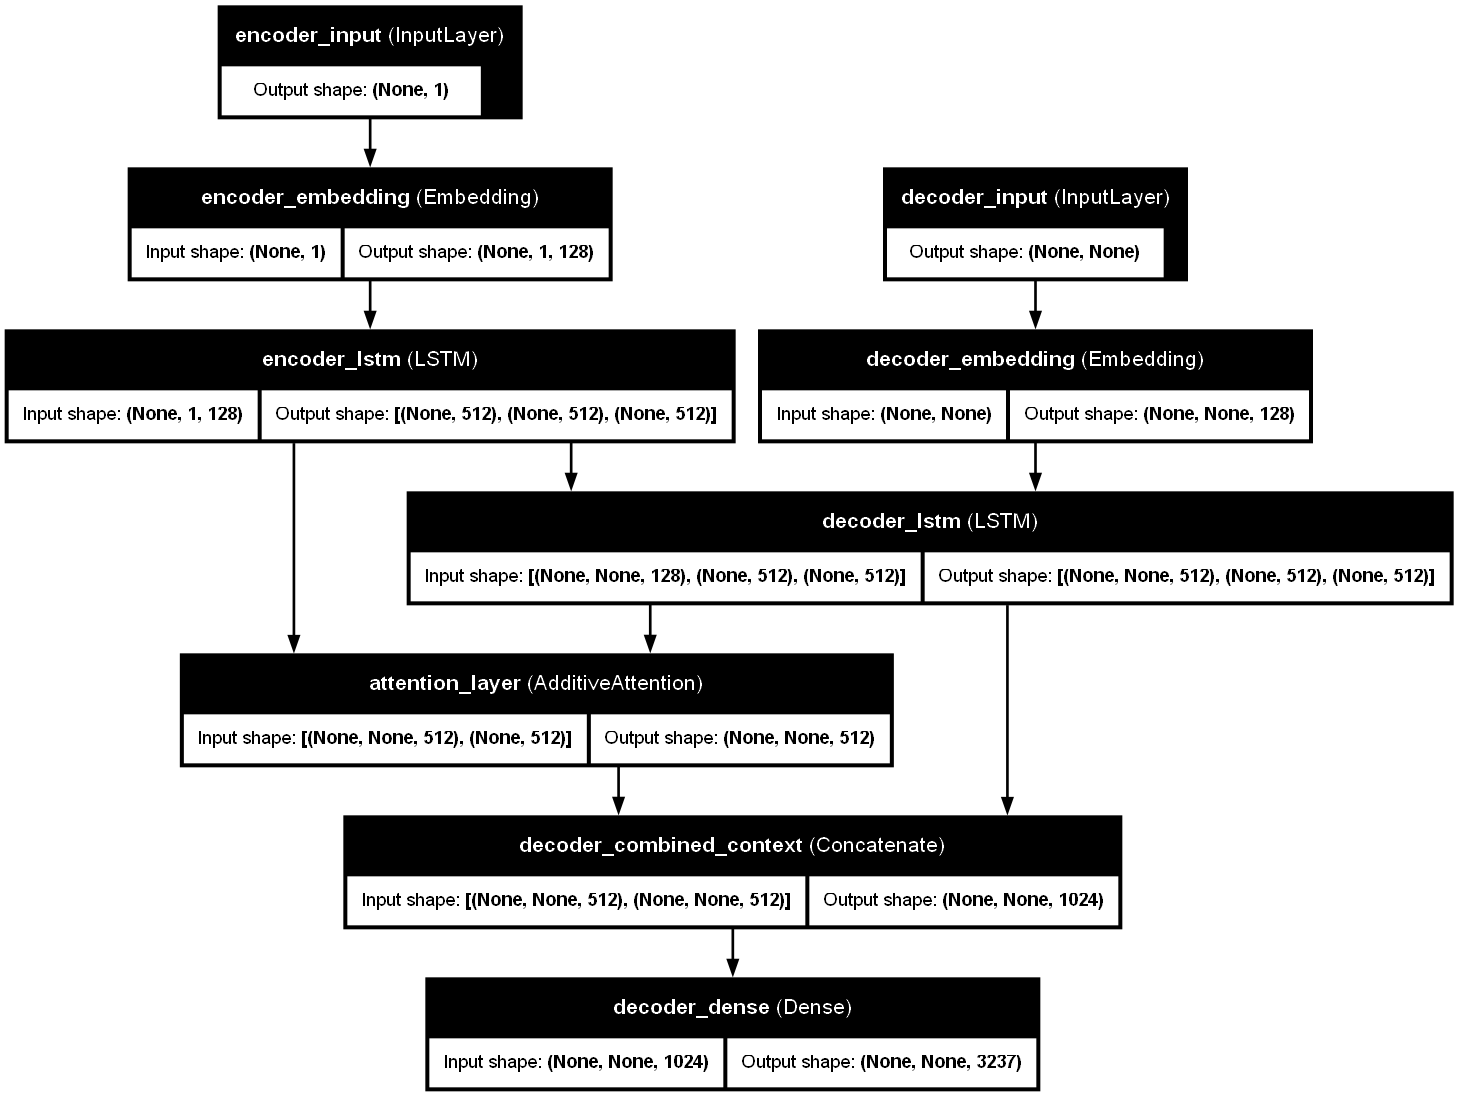

In [17]:
from keras.utils import plot_model

plot_model(
    model,
    to_file='model_architecture.png',  # File name to save the diagram
    show_shapes=True,                  # Display the input/output shapes
    show_layer_names=True,             # Show layer names in the diagram
    rankdir='TB',                      # Layout: 'TB' for top-to-bottom, 'LR' for left-to-right
    dpi=96                             # Resolution of the image
)

**Train the Model**

In [20]:
# Add to the training callbacks
history = model.fit(
    [train_input_sequences, decoder_input_data],
    decoder_target_data,
    batch_size=32,
    epochs=50,
    validation_data=(
        [val_input_sequences, val_decoder_input_data],
        val_decoder_target_data
    )
)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 183ms/step - accuracy: 0.3236 - loss: 6.1148 - val_accuracy: 0.4190 - val_loss: 3.7162
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 179ms/step - accuracy: 0.4051 - loss: 3.8784 - val_accuracy: 0.4407 - val_loss: 3.4055
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 178ms/step - accuracy: 0.4148 - loss: 3.5741 - val_accuracy: 0.4493 - val_loss: 3.1991
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 179ms/step - accuracy: 0.4282 - loss: 3.3534 - val_accuracy: 0.4713 - val_loss: 3.0451
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 181ms/step - accuracy: 0.4540 - loss: 3.1869 - val_accuracy: 0.4943 - val_loss: 2.9024
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 182ms/step - accuracy: 0.4789 - loss: 3.0305 - val_accuracy: 0.5080 - val_loss: 2.7687
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 179ms/step - accuracy: 0.4963 - loss: 2.8494 - val_accuracy: 0.5271 - val_loss: 2.6440
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 181ms/step - accuracy: 0.5111 - loss: 2

**Test the model**

In [21]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(
    [test_input_sequences, test_output_sequences[:, :-1]],  # Inputs
    test_output_sequences[:, 1:]                           # Targets
)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6653 - loss: 1.7986
Test Loss: 2.0142574310302734, Test Accuracy: 0.6317143440246582


In [21]:
print(test_input_sequences.shape)
print(test_output_sequences.shape)

(500, 1)
(500, 15)


**saving the model**

In [19]:
model.save(r'D:\PycharmProjects\source project files\8. Saved models\text generation\model0212_512.h5')

In [3]:
# Path to your saved model
model_path = r'D:\src_4_pro_dis_2\8. Saved models\text generation\model1212_512.h5'
# Load the model
new_model = load_model(model_path)
# Verify the model summary
# new_model.summary()

**Sampling search**

In [63]:
def hybrid_sampling(prob_dist, top_k=50, top_p=0.9, temperature=1.0):
    # Step 1: Apply temperature
    prob_dist = np.log(prob_dist) / temperature
    prob_dist = np.exp(prob_dist)
    prob_dist /= np.sum(prob_dist)  # Normalize probabilities

    # Step 2: Top-k Sampling
    top_k_indices = np.argsort(prob_dist)[-top_k:]
    top_k_probs = prob_dist[top_k_indices]

    # Step 3: Top-p Sampling
    sorted_indices = np.argsort(top_k_probs)[::-1]
    sorted_probs = top_k_probs[sorted_indices]
    cumulative_probs = np.cumsum(sorted_probs)
    cutoff = np.argmax(cumulative_probs >= top_p)
    top_p_indices = top_k_indices[sorted_indices[:cutoff + 1]]
    top_p_probs = prob_dist[top_p_indices]
    top_p_probs /= np.sum(top_p_probs)  # Normalize probabilities

    # Step 4: Random Sampling
    return np.random.choice(top_p_indices, p=top_p_probs)


def generate_sentence_with_attention(txt_model, input_sequence, output_index_word, max_seq_len=20, beam_width=5):
    # Initialize decoder input with the start token
    decoder_input = np.zeros((1, 1), dtype=int)  # Shape (batch_size, sequence_length)

    generated_tokens = []

    for _ in range(max_seq_len):
        # Predict probabilities for the next token
        predictions = txt_model.predict([input_sequence, decoder_input])
        prob_dist = predictions[0, -1, :]  # Extract the last timestep's probabilities

        # Decode using the hybrid sampling method
        next_token = hybrid_sampling(prob_dist, top_k=10, top_p=0.9, temperature=0.8)

        if next_token == 0:  # Stop token
            break
        generated_tokens.append(next_token)

        # Update decoder input for the next timestep
        decoder_input = np.hstack([decoder_input, [[next_token]]])  # Append next token to decoder input

    # Convert token indices to words
    generated_sentence = " ".join(output_index_word[token] for token in generated_tokens)
    return generated_sentence

input_word = "eat"
input_sequence = np.array([[input_word_to_index[input_word]]])  # Convert input word to its index

generated_sentence = generate_sentence_with_attention(new_model, input_sequence, output_index_word)
print("Generated Sentence:", generated_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Generated Sentence: the bat we bought last season?


In [ ]:
# --------------------------------------------------------------------------------------------------------------
# ---------------------------------Evaluations for LSTM model---------------------------------------------------
# --------------------------------------------------------------------------------------------------------------

**Perplexity**


In [32]:
import numpy as np

def calculate_perplexity(model, input_sequences, output_sequences):
    """
    Compute perplexity for the given model.
    :param model: Trained LSTM model.
    :param input_sequences: Array of input word sequences.
    :param output_sequences: Array of output word sequences (ground truth).
    :return: Perplexity score.
    """
    perplexities = []

    for input_seq, output_seq in zip(input_sequences, output_sequences):
        # Add a batch dimension
        input_seq = np.expand_dims(input_seq, axis=0)
        output_seq = np.expand_dims(output_seq, axis=0)

        # Predict probabilities for the output sequence
        predictions = model.predict([input_seq, output_seq[:, :-1]])

        # Calculate log probabilities
        log_probs = []
        for timestep, target_token in enumerate(output_seq[0, 1:]):  # Skip <start> token
            prob = predictions[0, timestep, target_token]
            log_probs.append(np.log(prob + 1e-9))  # Add small epsilon for numerical stability

        # Compute perplexity
        perplexity = np.exp(-np.mean(log_probs))
        perplexities.append(perplexity)

    # Average perplexity across all samples
    return np.mean(perplexities)

# Example Usage:
perplexity_score = calculate_perplexity(new_model, test_input_sequences, test_output_sequences)
print("Perplexity:", perplexity_score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

**BLEU Score**

In [30]:
from nltk.translate.bleu_score import sentence_bleu
import numpy as np

def calculate_bleu_score(model, input_sequences, output_sequences, output_index_word):
    """
    Compute BLEU score for a model's predictions compared to reference outputs.
    """
    bleu_scores = []

    for input_seq, reference_seq in zip(input_sequences, output_sequences):
        # Reshape input sequence to match the model's expected input
        input_seq = np.expand_dims(input_seq, axis=0)  # Shape: (1, 1)

        # Create a decoder input array filled with zeros (decoder input starts empty during inference)
        decoder_input = np.zeros((1, reference_seq.shape[0] - 1), dtype=int)  # Shape: (1, seq_len - 1)

        # Generate predictions
        predictions = model.predict([input_seq, decoder_input])  # Shape: (1, seq_len - 1, vocab_size)

        # Extract predicted tokens
        predicted_tokens = np.argmax(predictions[0], axis=-1)  # Shape: (seq_len - 1,)

        # Convert token indices to words
        predicted_sentence = [output_index_word[token] for token in predicted_tokens if token != 0]
        reference_sentence = [output_index_word[token] for token in reference_seq if token != 0]

        # Compute BLEU score for the generated sentence
        bleu_score = sentence_bleu([reference_sentence], predicted_sentence)
        bleu_scores.append(bleu_score)

    return np.mean(bleu_scores)

# Example Usage
bleu_score = calculate_bleu_score(new_model, test_input_sequences, test_output_sequences, output_index_word)
print("BLEU Score:", bleu_score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

**Distinct-N**

In [35]:
from collections import Counter

def calculate_distinct_n(generated_sentences, n=1):
    """
    Compute Distinct-N metric for diversity.
    :param generated_sentences: List of generated sentences.
    :param n: n-gram size (e.g., 1 for unigram, 2 for bigram).
    :return: Distinct-N score.
    """
    all_ngrams = []
    for sentence in generated_sentences:
        tokens = sentence.split()
        ngrams = zip(*[tokens[i:] for i in range(n)])  # Generate n-grams
        all_ngrams.extend(ngrams)

    unique_ngrams = set(all_ngrams)
    return len(unique_ngrams) / len(all_ngrams) if all_ngrams else 0

# Example Usage:
# Generate sentences from the model
generated_sentences = [
    generate_sentence_with_attention(new_model, np.expand_dims(input_seq, axis=0), output_index_word)
    for input_seq in test_input_sequences
]

# Compute Distinct-N
distinct_1 = calculate_distinct_n(generated_sentences, n=1)  # Distinct-1 (unigrams)
distinct_2 = calculate_distinct_n(generated_sentences, n=2)  # Distinct-2 (bigrams)
print("Distinct-1:", distinct_1)
print("Distinct-2:", distinct_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━